In [1]:
from scipy.stats import t, norm, chi2, binom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Sample Autocorrelation $\hat{p}_k$ at lag $k$
$$\hat{p}_k = \frac{\frac{1}{N} \sum_{i=1}^{N-k} (x_i - \overline{x})(x_{i+k} - \overline{x})}{\frac{1}{N} \sum_{i=1}^N (x_i - \overline{x})^2}$$

In [3]:
def autocorrelation(chain, k, normalize_autocovariance_with_n_k=False):
    """
    Given a lag k where 1 <= k <= len(chain) - 1, return the sample autcorrelation at lag k of the Markov chain.
    Note that computing the autocorrelation at some lag k only makes sense if the chain is covariance stationary.
    
    Note that the default setting here is to normalize the autocovariance with 1/N as written in the equation above,
    and not 1/(N-k) as written in some textbooks.
    
    This is to keep the function bounded between -1 and 1, and to prevent high values for the ACF at big lags.
    """
    
    assert (0 <= k <= len(chain) - 1), "Chosen value k for lag is not within bounds"
    assert (np.var(chain) > 0), "Chain has unadjusted sample variance of 0"
    
    if k == 0:
        return 1
    
    mean = np.mean(chain)
    length = len(chain)
    
    normalizing_divisor = length
    if normalize_autocovariance_with_n_k:
        normalizing_divisor = length - k
    
    # Compute the numerator
    autocovariance = (1/normalizing_divisor)*np.dot(chain[:-k] - mean, chain[k:] - mean)

    # The denominator is the adjusted sample variance
    autocorrelation = autocovariance/np.var(chain)
    
    return autocorrelation

def acf_array(chain, max_lag=0):
    length = len(chain)
    assert (length > 0), "Chain is empty"
    
    if max_lag == 0:
        max_lag = length - 1
    
    assert (1 <= max_lag <= length - 1), "Value for maximum lag is not within bounds"
    
    autocorrelations = []
    for lag in range(1, max_lag + 1):
        autocorrelations.append(autocorrelation(chain, lag))
    return autocorrelations

def plot_acf(chain, max_lag=0):
    acfs = acf_array(chain, max_lag)
    
    fig, ax = plt.subplots(1,1)
    ax.plot(np.arange(1, len(chain)), acfs)
    ax.set_xlabel("Lag k")
    ax.set_ylabel("Sample Autocorrelation")
    ax.axhline(y = 0, color='k')
    ax.grid(b=True)

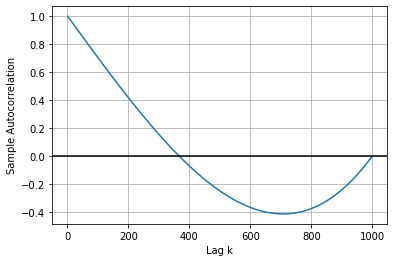

In [4]:
sample = np.linspace(1, 10, 1000)
plot_acf(sample)

With a random sample, we expect low autocorrelation, which is exactly what we get as shown below.

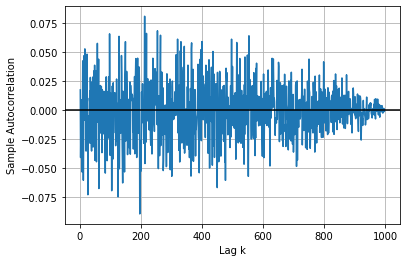

In [5]:
random_sample = np.random.default_rng().standard_normal(1000)
plot_acf(random_sample)

## Comparison with Pandas' autocorrelation_plot()

In [6]:
series = pd.read_csv("temp.csv", header=0, index_col=0)

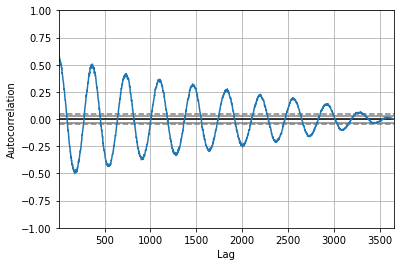

In [10]:
pd.plotting.autocorrelation_plot(series)

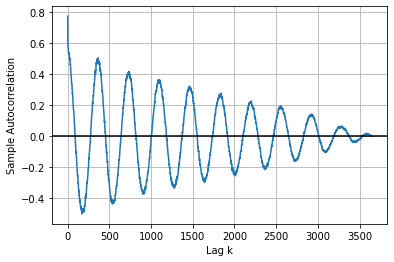

In [11]:
plot_acf(series.values.reshape(3650))

# Covariance and Correlation

In [2]:
def covariance(x):
    """
    x is a 2 x n array where n > 1 and each row is a sample of a different random variable
    """
    sample_mean = x.mean(axis=1).reshape(2,1)
    normalized_x = x - sample_mean.reshape(2,1)
    covariance = (1/(np.size(x, 1)-1))*(normalized_x[0]*normalized_x[1]).sum()
    return covariance
    
def pearson_correlation(x):
    """
    x is a 2 x n array where n > 1 and the each row is a sample of a different random variable
    """
    return covariance(x)/(np.std(x[0], ddof=1)*np.std(x[1], ddof=1))

# Wilcoxon Signed Rank Test
Let
    $$W = \sum \text{sgn} (x_i - y_i) R_i$$
be the signed rank sum.

Note that $R_i$ is the positive number between $1$ and $n$ where $n$ is the sample size, ordered from lowest absolute value at $1$ to highest absolute value at $n$. For example, given the array of differences
$$[-3, 1, 2, 2]$$
we have $R_1 = 4, R_2 = 1, R_3 = R_4 = 2.5$ where $R_3, R_4$ are each incremented by half because they share the same place.

Then
    $$\frac{W - 0}{\sqrt{\frac{n(n+1)(2n+1)}{6}}} \sim N(0, 1).$$

In [36]:
def wilcoxon_signed_rank_sum(x):
    """
    Given a numpy 1 x n array of the differences, calculate the signed rank sum
    Note that the array of differences is equal to {x_i - y_i} in the above equation
    """
    temp = np.absolute(x).argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(x))
    ranks = ranks + 1
    signed_indices = np.where(x > 0, 1, -1)
    signed_ranks = np.multiply(signed_indices, ranks)
    return np.sum(signed_ranks)

def wilcoxon_test_statistic(x):
    """
    Given a numpy 1 x n array of the differences, calculate the test statistic
    """
    n = np.size(x)
    return wilcoxon_signed_rank_sum(x)/math.sqrt(n*(n+1)*(2*n+1)/6)

def wilcoxon_p_val(x):
    # p-value = P(|Z| >= wilcoxon test statistic) = 2*P(Z <= -abs(wilcoxon test statistic))
    # by symmetry of the normal distribution
    return 2*norm.cdf(-abs(wilcoxon_test_statistic(x)))

In [33]:
x = np.array([-13.2, -10.5, -10.5,  -9.2,  -8.3,  -7.7,  -5.9,  -5.5,  -4.6,
        -3.8,  -3.2,  -1. ,  -0.1,   0.4,   5.2])

In [35]:
wilcoxon_p_val(x)

0.003772239574473987

# Chi-square Goodness of Fit Test

In [14]:
def chi2_goodness_of_fit_p_val(observed, h0_parameters):
    """
    observed - (n, ) numpy array of the observed number of each class
    parameters - (n, ) numpy array of the null hypothesis proportions for each class in the same order as 'observed'
    """
    assert np.size(observed) == np.size(h0_parameters)
    
    num_of_categories = np.size(observed)
    n = np.sum(observed)
    expected = n*h0_parameters
    normalized_matrix = (observed - expected)**2/expected
    test_statistic = np.sum(normalized_matrix)
    
    # p-value = P(chi-square, df = n-1 >= test statistic)
    return 1 - chi2.cdf(test_statistic, df=num_of_categories-1)

# Chi-square Homogeneity/Independence Test

In [38]:
def chi2_homogeneity_test_statistic(array):
    column_totals = array.sum(axis=0)
    h0_col_proportions = column_totals/column_totals.sum()
    row_totals = array.sum(axis=1).reshape(-1, 1) # reshape for broadcasting
    h0_values = h0_col_proportions*row_totals
    print("h0_values:")
    print(h0_values)
    normalized_matrix = (np.square(array - h0_values)/h0_values)
    print("normalized_matrix:")
    print(normalized_matrix)
    test_statistic = normalized_matrix.sum()
    print("test statistic: {}".format(test_statistic))
    return test_statistic

def chi2_homogeneity_p_val(array):
    """
    Given a numpy array, compute the p val of the homogeneity/independence of the variables.
    High homogeneity/independence will have a low Chi-square value because the differences will be small.
    Low homogeneity/independence will have a high Chi-square value because the differences will be large.
    """
    df = (np.size(array, 0)-1)*(np.size(array, 1)-1)
    print("df = (number of rows - 1)*(number of columns - 1) = {}".format(df))
    p_val = 1 - chi2.cdf(chi2_homogeneity_test_statistic(array), df=df)
    return p_val

x = np.array([[21, 16, 145, 2, 6], [14, 4, 175, 13, 4]])
chi2_homogeneity_p_val(x)

df = (number of rows - 1)*(number of columns - 1) = 4
h0_values:
[[ 16.625   9.5   152.      7.125   4.75 ]
 [ 18.375  10.5   168.      7.875   5.25 ]]
normalized_matrix:
[[1.15131579 4.44736842 0.32236842 3.68640351 0.32894737]
 [1.04166667 4.02380952 0.29166667 3.33531746 0.29761905]]
test statistic: 18.926482873851295


0.0008125174740349905

# Mean

## Confidence Interval for Mean

In [4]:
def confidence_interval_mean(array, tail=0, alpha=0.05):
    """
    We assume population variance is unknown and use the t distribution and sample mean and variance 
    to estimate a confidence interval for the population mean.
    
    tail: if -1, then one-tailed lower bound,
              0, then two-tailed
              1, then one-tailed upper bound
    """
    assert tail in [-1, 0, 1]
    
    mean = np.mean(array)
    s = np.std(array, ddof=1)
    n = np.size(array, 0)
    
    divisor_of_alpha = 2-abs(tail)
    test_statistic = t.ppf(1-alpha/divisor_of_alpha, df=n-1)*s/math.sqrt(n)
    coefficient_vector = np.array([-1, 1])
    
    if tail == -1:
        coefficient_vector = np.array([-1, np.inf])
    elif tail == 1:
        coefficient_vector = np.array([-np.inf, 1])
        
    return mean + coefficient_vector*test_statistic

def confidence_interval_mean(sample_mean, sample_size, std, tail=0, alpha=0.05):
    """
    We assume population variance is unknown and use the t distribution and sample mean and variance 
    to estimate a confidence interval for the population mean.
    
    tail: if -1, then one-tailed lower bound,
              0, then two-tailed
              1, then one-tailed upper bound
    """
    assert tail in [-1, 0, 1]
    
    mean = sample_mean
    s = std
    n = sample_size
    
    divisor_of_alpha = 2-abs(tail)
    test_statistic = t.ppf(1-alpha/divisor_of_alpha, df=n-1)*s/math.sqrt(n)
    coefficient_vector = np.array([-1, 1])
    
    if tail == -1:
        coefficient_vector = np.array([-1, np.inf])
    elif tail == 1:
        coefficient_vector = np.array([-np.inf, 1])
        
    return mean + coefficient_vector*test_statistic

confidence_interval_mean(7, 30, 3, tail=1)


array([     -inf, 7.9306502])

## Hypothesis Test for Mean

In [5]:
def mean_p_val_array(array, h0_mean, tail=0):
    """
    Given a numpy array of iid samples from a normal distribution and h0 mean, determine the p-value.
    """
    array = np.array(array)
    return mean_p_val(np.mean(array), np.size(array), np.std(array, ddof=1), h0_mean, tail=tail)

def mean_p_val(sample_mean, sample_size, std, h0_mean, std_is_pop_std=False, tail=0):
    """
    We assume the population is distributed under a normal distribution and determine the p-value.
    
    tail: if -1, then one-tailed lower bound,
              0, then two-tailed
              1, then one-tailed upper bound
    """
    assert tail in [-1, 0, 1]
    
    
    divisor_of_alpha = 2-abs(tail)
    test_statistic = (sample_mean - h0_mean)/(std/math.sqrt(sample_size))
    p_val = 1 # set arbitrary value for p-val
    
    if tail == -1:
        # p-val = P(t <= test_statistic)
        if std_is_pop_std:
            p_val = norm.cdf(test_statistic)
        else: 
            p_val = t.cdf(test_statistic, df=sample_size-1)
    elif tail == 0:
        # p-val = P(|t| >= |test_statistic|) = 2*P(t <= -|test_statistic)
        # by the symmetry of the t distribution
        if std_is_pop_std:
            p_val = 2*norm.cdf(-abs(test_statistic))
        else:
            p_val = 2*t.cdf(-abs(test_statistic), df=sample_size-1)
    elif tail == 1:
        # p-val = P(t >= test_statistic)
        if std_is_pop_std:
            p_val = 1 - norm.cdf(test_statistic)
        else:
            p_val = 1 - t.cdf(test_statistic, df=sample_size-1)
        
    return p_val

mean_p_val(sample_mean = 5, sample_size=20, std=1, h0_mean = 10, tail=-1)

2.0759016533708336e-15

## Confidence Interval for Difference of Means

## Hypothesis Test for Difference of Means

Given two samples $x, y$ with standard deviation $s_x, s_y$ and sample size $n_x, n_y$, the test statistic $T$ is
    $$T = \frac{\bar{x} - \bar{y}}{\sqrt{\frac{s_x^2}{n_x} + \frac{s_y^2}{n_y}}}$$
where $T \sim t_{\text{df} = \nu}$ and $\nu$ is the Welch's degree of freedom.

### Welch's $\nu$ Degrees of Freedom

Given two samples $x, y$ with standard deviation $s_x, s_y$ and sample size $n_x, n_y$, respectively, Welch's $\nu$ degrees of freedom is defined as
$$\nu = \frac{(\frac{s_x^2}{n_x} + \frac{s_y^2}{n_y})^2}{\frac{s_x^4}{n_x^2(n_x - 1)} + \frac{s_y^4}{n_y^2(n_y - 1)}}.$$

In [7]:
def welch_df(s1, s2, n1, n2):
    return math.floor((s1**2/n1 + s2**2/n2)**2/((1/(n1-1))*(s1**2/n1)**2 + (1/(n2-1))*(s2**2/n2)**2))

In [8]:
def difference_of_means_p_val(x1_mean, x2_mean, n1, n2, s1, s2, tail=0):
    """
    We assume the population is a normal distribution and determine the p-value.
    
    tail: if -1, then one-tailed lower bound: x1_mean - x2_mean < 0,
              0, then two-tailed: x1_mean - x2_mean != 0,
              1, then one-tailed upper bound: x1_mean - x2_mean > 0,
    """
    assert tail in [-1, 0, 1]
    
    test_statistic = (x1_mean - x2_mean)/math.sqrt(s1**2/n1 + s2**2/n2)
    p_val = 1 # set arbitrary value for p-val
    
    df = math.floor(welch_df(s1, s2, n1, n2))
    
    if tail == -1:
        # p-val = P(t <= test_statistic)
        p_val = t.cdf(test_statistic, df=df)
    elif tail == 0:
        # p-val = P(|t| >= |test_statistic|) = 2*P(t <= -|test_statistic)
        # by the symmetry of the t distribution
        p_val = 2*t.cdf(-abs(test_statistic), df=df)
    elif tail == 1:
        # p-val = P(t >= test_statistic)
        p_val = 1 - t.cdf(test_statistic, df=df)
        
    return p_val

# Variance

## Confidence Interval for Variance

In [1]:
def confidence_interval_variance(array, tail=0, alpha=0.05):
    """
    We use the Chi-square distribution to estimate a confidence interval for the population variance.
    
    tail: if -1, then one-tailed lower bound,
              0, then two-tailed
              1, then one-tailed upper bound
    """
    assert tail in [-1, 0, 1]
    
    s = np.std(array, ddof=1)
    n = np.size(array, 0)
    
    divisor_of_alpha = 2-abs(tail)
    lower_bound = (n-1)*s**2/chi2.ppf(1-alpha/divisor_of_alpha, df=n-1)
    upper_bound = (n-1)*s**2/chi2.ppf(alpha/divisor_of_alpha, df=n-1)
    coefficient_vector = np.array([1,1])
    
    if tail == -1:
        coefficient_vector = np.array([1, np.inf])
    elif tail == 1:
        coefficient_vector = np.array([0, 1])
        
    return coefficient_vector * np.array([lower_bound, upper_bound])

## Hypothesis Test for Variance

We reject the null hypothesis if the p-value is less than or equal to $\alpha$. While the p-values for the left and right tail are obvious, the two-tailed test requires taking the minimum of the left and right tails and then doubling it.

If our confidence level is $\alpha$, then we reject $H_0$ if our test statistic $X^2$ is in one of either two scenarios:
$$X^2 \leq \mathcal{X}^2_{\alpha/2} \iff P(\mathcal{X}^2 \leq X^2) \leq \frac{\alpha}{2} \iff 2P(\mathcal{X}^2 \leq X^2) \leq \alpha,$$
or
$$X^2 \geq \mathcal{X}^2_{\alpha/2} \iff P(\mathcal{X}^2 \geq X^2) \leq \frac{\alpha}{2} \iff 2P(\mathcal{X}^2 \geq X^2) \leq \alpha,$$
where $\mathcal{X}^2$ is a chi-square random variable with $n-1$ degrees of freedom where $n$ is the sample size.

This can be summarized by rejecting $H_0$ if
$$\min(2P(\mathcal{X}^2 \leq X^2), 2P(\mathcal{X}^2 \geq X^2)) = 2\min(P(\mathcal{X}^2 \leq X^2), P(\mathcal{X}^2 \geq X^2)) \leq \alpha.$$
Thus we should define the p-value of the two tailed test as such
    $$\text{p-value} = 2\min(P(\mathcal{X}^2 \leq X^2), P(\mathcal{X}^2 \geq X^2)).$$

In [2]:
def variance_p_val(sample_variance, sample_size, h0_variance, tail=0):
    """
    We assume the population is a normal distribution and determine the p-value.
    
    tail: if -1, then one-tailed lower bound,
              0, then two-tailed
              1, then one-tailed upper bound
    """
    assert tail in [-1, 0, 1]
    
    test_statistic = (sample_size -1)*sample_variance/h0_variance
    p_val = 1 # set arbitrary value for p-val
    
    if tail == -1:
        # p-val = P(chi-square <= test_statistic)
        p_val = chi2.cdf(test_statistic, df=sample_size-1)
    elif tail == 0:
        # p-val = 2*min(P(chi-square <= test_statistic), P(chi-square >= test_statistic))
        p_val = 2*min(chi2.cdf(test_statistic, df=sample_size-1), 1 - chi2.cdf(test_statistic, df=sample_size-1))
    elif tail == 1:
        # p-val = P(t >= test_statistic)
        p_val = 1 - chi2.cdf(test_statistic, df=sample_size-1)
        
    return p_val

# Proportion

## Confidence Interval for Proportion

In [57]:
def confidence_interval_proportion(p, n, tail=0, alpha=0.05):
    """
    We estimate a confidence interval for the population proportion.
    
    tail: if -1, then one-tailed lower bound,
              0, then two-tailed
              1, then one-tailed upper bound
    """
    assert tail in [-1, 0, 1]
    
    divisor_of_alpha = 2-abs(tail)
    test_statistic = norm.ppf(1-alpha/divisor_of_alpha)*math.sqrt(p*(1-p)/n)
    coefficient_vector = np.array([-1, 1])
    
    if tail == -1:
        coefficient_vector = np.array([-1, 1.1/(test_statistic)]) # 1.1 is arbitrary, the upper bound should always be 1
    elif tail == 1:
        coefficient_vector = np.array([0, 1])
        
    unbounded_ci = p + coefficient_vector*test_statistic
    bounded_ci = -1*(unbounded_ci < 0)*unbounded_ci + unbounded_ci + -1*(unbounded_ci > 1)*(unbounded_ci-1)
    return bounded_ci
    
confidence_interval_proportion(p=28/400, n=400, tail=-1, alpha=0.01)

array([0.04032196, 1.        ])

## Hypothesis Test for Difference of Proportions

Although the standard error of the difference $p_1 - p_2$ is
    $$\sqrt{\frac{\hat{p_1} (1-\hat{p_1})}{n_1} + \frac{\hat{p_2} (1-\hat{p_2})}{n_2}},$$
when we do the hypothesis test, we assume $p_1 = p_2$, and therefore need to change $\hat{p_1}, \hat{p_2}$ in the standard error to an average
    $$\hat{p} = \frac{n_1 \hat{p_1} + n_2 \hat{p_2}}{n_1 + n_2}.$$
Then our standard error becomes
    $$\sqrt{\hat{p} (1-\hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}.$$

In [10]:
def difference_of_proportions_p_val(p1, p2, n1, n2, tail=0):
    """
    
    tail: if -1, then one-tailed lower bound: p1 - p2 < 0,
              0, then two-tailed: p1 - p2 != 0,
              1, then one-tailed upper bound: p1 - p2 > 0,
    """
    assert tail in [-1, 0, 1]
    
    average_p = (n1*p1 + n2*p2)/(n1+n2)
    test_statistic = (p1-p2)/math.sqrt(average_p*(1-average_p)*(1/n1 + 1/n2))
    p_val = 1 # set arbitrary value for p-val
    
    if tail == -1:
        # p-val = P(Z <= test_statistic)
        p_val = norm.cdf(test_statistic)
    elif tail == 0:
        # p-val = P(|Z| >= |test_statistic|) = 2*P(Z <= -|test_statistic)
        # by the symmetry of the normal distribution
        p_val = 2*norm.cdf(-abs(test_statistic))
    elif tail == 1:
        # p-val = P(Z >= test_statistic)
        p_val = 1 - norm.cdf(test_statistic)
        
    return p_val